In [1]:
from keras import layers
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Activation
#matplotlib inline

latent_dim=100
height=28
width=28
channels=1

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
generator_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(128 * 7 * 7)(generator_input)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
x = layers.Conv2D(128, 4, padding='same')(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = Activation('relu')(x)
x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
x = layers.Conv2D(64, 4, padding='same')(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = Activation('relu')(x)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)

generator = Model(generator_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0         
__________

In [3]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(32, 3, strides=2, padding='same')(discriminator_input)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(64, 4, strides=2, padding='same')(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(256, 4, strides=1, padding='same')(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = Model(discriminator_input, x)
discriminator_optimizer = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(optimizer=discriminator_optimizer,
                      loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          32832     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

In [4]:
gan_input = layers.Input(shape=(latent_dim,))

# Discriminator는 학습 하지 않도록 설정 
discriminator.trainable = False
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_optimizer = Adam(lr=0.0002, beta_1=0.5)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [5]:
(X_train, _), (_, _) = mnist.load_data()

# Generator의 마지막 활성화 함수를 'tanh(.)'를 사용했기 때문에, (-1 ~ 1) 로 스케일링 해준다.
X_train = X_train.astype(np.float32) / 127.5 - 1 
X_train = np.expand_dims(X_train, axis=-1)

In [7]:
batch_size = 32

def train(epochs, print_step=100):
    history = []
    for epoch in range(epochs):
        
        # 실제 이미지 Batch 추출
        real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]
        real_label = np.ones((batch_size, 1))
        
        # 이미지 생성
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        generated_images = generator.predict(noise)
        fake_label = np.zeros((batch_size, 1))
        
        # label에 Noise 추가 
        real_label += 0.05 * np.random.normal(0, 1, size=real_label.shape)
        fake_label += 0.05 * np.random.normal(0, 1, size=fake_label.shape)
        
        # discriminator 학습
        d_loss_real = discriminator.train_on_batch(real_images, real_label)
        d_loss_fake = discriminator.train_on_batch(generated_images, fake_label)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Generator 학습
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # 기록
        record = (epoch, d_loss[0], 100 * d_loss[1], g_loss)
        history.append(record)

        if epoch % print_step == 0:
            print(
                "%5d [D loss: %.3f, acc.: %.2f%%] [G loss: %.3f]" % record)

In [8]:
%%time
history1000 = train(1000, 100)

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


    0 [D loss: 1.367, acc.: 0.00%] [G loss: 1.030]
  100 [D loss: 0.797, acc.: 0.00%] [G loss: 1.543]
  200 [D loss: 0.846, acc.: 0.00%] [G loss: 1.109]
  300 [D loss: 0.873, acc.: 0.00%] [G loss: 0.992]
  400 [D loss: 0.847, acc.: 0.00%] [G loss: 1.062]
  500 [D loss: 0.710, acc.: 0.00%] [G loss: 1.062]
  600 [D loss: 0.722, acc.: 0.00%] [G loss: 1.057]
  700 [D loss: 0.833, acc.: 0.00%] [G loss: 1.075]
  800 [D loss: 0.737, acc.: 0.00%] [G loss: 1.145]
  900 [D loss: 0.688, acc.: 0.00%] [G loss: 1.115]
Wall time: 1min 40s


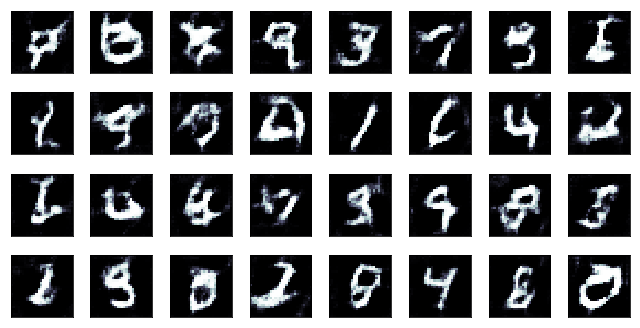

In [9]:
def show_images(generated_images, n=4, m=8, figsize=(9, 5)):
    fig = plt.figure(figsize=figsize)
    plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
    for i in range(n):
        for j in range(m):
            k = i * m + j
            ax = fig.add_subplot(n, m, i * m + j + 1)
            ax.imshow(generated_images[k][:, :, 0], cmap=plt.cm.bone)
            ax.grid(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
    plt.tight_layout()
    plt.show()


noise_data = np.random.normal(0, 1, size=(32, latent_dim))
show_images(0.5 * generator.predict(noise_data) + 0.5)

In [10]:
def save_models(epoch):
    generator.save("dcgan_generator_{}.hdf5".format(epoch))
    discriminator.save("dcgan_discriminator_{}.hdf5".format(epoch))
    gan.save("dcgan_combined_{}.hdf5".format(epoch))


save_models(1000)

In [11]:
%%time
history4000 = train(3000, 1000)

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


    0 [D loss: 0.718, acc.: 0.00%] [G loss: 1.028]
 1000 [D loss: 0.655, acc.: 0.00%] [G loss: 0.960]
 2000 [D loss: 0.732, acc.: 0.00%] [G loss: 0.867]
Wall time: 4min 50s


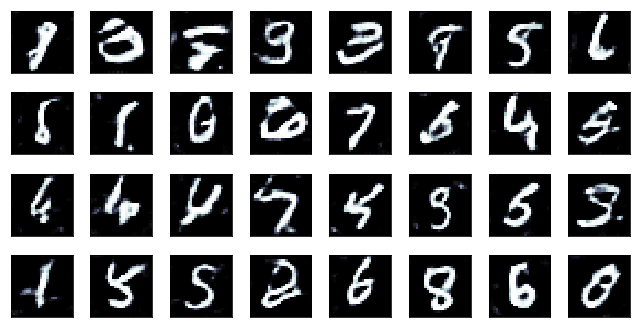

In [13]:
show_images(0.5 * generator.predict(noise_data) + 0.5)
save_models(4000)

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


    0 [D loss: 0.642, acc.: 0.00%] [G loss: 1.155]
 2000 [D loss: 0.524, acc.: 0.00%] [G loss: 1.479]
 4000 [D loss: 0.564, acc.: 0.00%] [G loss: 1.230]


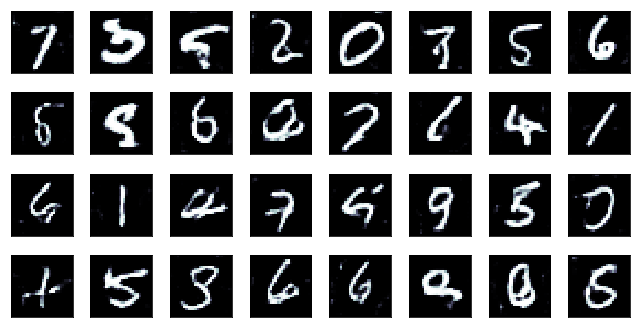

Wall time: 9min 36s


In [14]:
%%time
history10000 = train(6000, 2000)
show_images(0.5 * generator.predict(noise_data) + 0.5)
save_models(10000)